# TEXT CNN WORKFLOW (UCI DATASET)
Status: **DONE**

In [1]:
# IMPORT ALL LIBRARIES
import sys
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))


from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from shared.metrics import compute_classic_metrics, save_evaluation_report

importlib.reload(sys.modules['shared.metrics'])


<module 'shared.metrics' from 'c:\\Users\\mosqu\\personal-projects\\dss_pit\\src\\shared\\metrics.py'>

In [12]:
df = pd.read_csv("../../../data/uci/cleaned_covid_lies.csv")

df.columns = ["X", "Y"]

print(df)
print(df.isna().sum())
print( "Shape: ", df.shape)

                                                      X   Y
0                    coronavirus genetically engineered  na
1      blowing conch shell destroys coronavirus potency  na
2     swan dolphin swimming venice canal following c...  na
3                              cocaine cure coronavirus  na
4     observing janata curfew result reduction covid...  na
...                                                 ...  ..
6586             safe individual infected covid go work  na
6587                         vitamin c cure coronavirus  na
6588                           cocaine cure coronavirus  na
6589               lion freed keep people street moscow  na
6590            holy communion cause spread coronavirus  na

[6591 rows x 2 columns]
X    0
Y    0
dtype: int64
Shape:  (6591, 2)


In [13]:
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(df["Y"])

y_one_hot = to_categorical(y_encoded)

print(f"Original labels: {label_encoder.classes_}")
print(f"One-hot encoded shape: {y_one_hot.shape}")

Original labels: ['na' 'neg' 'pos']
One-hot encoded shape: (6591, 3)


In [14]:
VOCAB_SIZE = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(df["X"])

sequences = tokenizer.texts_to_sequences(df["X"])
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Padded sequence shape: {X_padded.shape}")

Padded sequence shape: (6591, 100)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    y_one_hot,
    test_size=0.2,    # 20% for testing
    random_state=42,
    stratify=y_one_hot # Ensures proportional representation of each class
)

print(f"Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Train set shape: (5272, 100), (5272, 3)
Test set shape: (1319, 100), (1319, 3)


In [ ]:
# CNN PARAMETER CONFIGURATION

# --- Model Hyperparameters ---
EMBEDDING_DIM = 100
FILTER_SIZES = [3, 4, 5] # Kernel sizes for the Conv1D layers
NUM_FILTERS = 128
DROPOUT_RATE = 0.5
NUM_CLASSES = y_one_hot.shape[1] 

# 1. Input Layer
input_layer = Input(shape=(MAX_LEN,))

# 2. Embedding Layer
embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    input_length=MAX_LEN
)(input_layer)

# 3. Convolutional and Pooling Blocks (Parallel Conv1D with different kernel sizes)
conv_blocks = []
for fz in FILTER_SIZES:
    conv = Conv1D(
        filters=NUM_FILTERS,
        kernel_size=fz,
        activation='relu'
    )(embedding_layer)
    # GlobalMaxPooling1D pools across the entire feature map (takes the max value)
    pooled = GlobalMaxPooling1D()(conv)
    conv_blocks.append(pooled)

# 4. Concatenation and Dropout
# Concatenate the outputs from all pooling layers
merged = Concatenate()(conv_blocks)
dropout = Dropout(DROPOUT_RATE)(merged)

# 5. Output Layer
# Use 'softmax' for multi-class classification
output_layer = Dense(NUM_CLASSES, activation='softmax')(dropout)

# Create the final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
# Use 'categorical_crossentropy' loss for multi-class classification
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

c:\Users\mosqu\personal-projects\dss_pit\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 128)   │     38,528 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 97, 128)   │     51,328 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 96, 128)   │     64,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │      1,155 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,155,139 (4.41 MB)

 Trainable params: 1,155,139 (4.41 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
# EARLY STOPPING DEFINITION

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Stop after 5 epochs of no improvement
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [early_stopping]

In [18]:
# --- Training Configuration ---
BATCH_SIZE = 32
EPOCHS = 50

print("Starting model training...")

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1, # Use 10% of the training data as a validation set
    callbacks = callbacks_list,
    verbose=1
)

print("Training finished.")

Starting model training...
Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9288 - loss: 0.2783 - val_accuracy: 0.9205 - val_loss: 0.2420
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9328 - loss: 0.2073 - val_accuracy: 0.9186 - val_loss: 0.2311
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9376 - loss: 0.1975 - val_accuracy: 0.9205 - val_loss: 0.2268
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9330 - loss: 0.1993 - val_accuracy: 0.9205 - val_loss: 0.2229
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9344 - loss: 0.1988 - val_accuracy: 0.9223 - val_loss: 0.2208
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9361 - loss: 0.1959 - val_accuracy: 0.9205 - val_loss: 0.2217
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9355 - loss: 0.1939 - val_accuracy: 0.9223 - val_loss: 0.2176
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.935

In [19]:
# EVALUATION

print("\nEvaluating model on test set...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Making predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert one-hot test labels back to class indices for comparison
y_true_classes = np.argmax(y_test, axis=1)

# Display a classification report (requires scikit-learn metrics)
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=label_encoder.classes_
))


Evaluating model on test set...
Test Loss: 0.2122
Test Accuracy: 0.9401
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Classification Report:
              precision    recall  f1-score   support

          na       0.95      0.99      0.97      1230
         neg       0.53      0.29      0.38        31
         pos       0.59      0.17      0.27        58

    accuracy                           0.94      1319
   macro avg       0.69      0.49      0.54      1319
weighted avg       0.92      0.94      0.93      1319



In [20]:
metrics = compute_classic_metrics(y_true_classes, y_pred_classes)

print("Accuracy:", metrics["accuracy"])
print("F1 Score:", metrics["f1_score"])
print(metrics["report"])

Accuracy: 0.9401061410159212
F1 Score: 0.9259968744520495
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1230
           1       0.53      0.29      0.38        31
           2       0.59      0.17      0.27        58

    accuracy                           0.94      1319
   macro avg       0.69      0.49      0.54      1319
weighted avg       0.92      0.94      0.93      1319



In [21]:
# PLOT CONFUSION MATRIX
class_names = label_encoder.classes_

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Raw confusion matrix:")
print(cm)

Raw confusion matrix:
[[1221    3    6]
 [  21    9    1]
 [  43    5   10]]


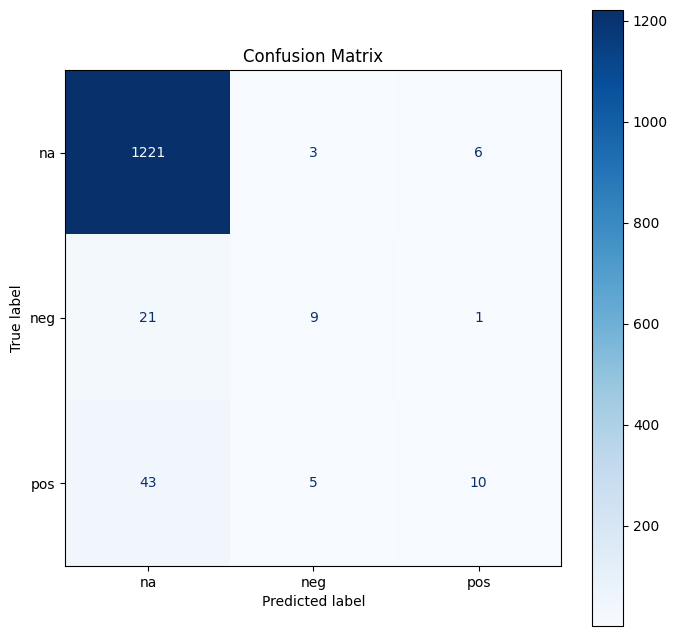

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Adjust the plot size and color map
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d') # 'd' formats as integer
plt.title("Confusion Matrix")
plt.show()

In [23]:
# SAVE EVAL REPORT
save_evaluation_report(metrics, "../../../deep_models/uci_results/textcnn_evaluation_report.json")

Evaluation report saved to ../../../deep_models/uci_results/textcnn_evaluation_report.json


In [24]:
# SAVE MODEL AND TOKENIZER

# Save the Keras model
model.save('../../../shared/models/textcnn_uci_model.keras')

# Save the Tokenizer
import pickle
with open('../../../shared/tokenizers/textcnn_uci_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nModel and Tokenizer saved successfully.")


Model and Tokenizer saved successfully.
